# Import Dependencies

In [1]:
import os 
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt

from pygments.formatters import img
from tqdm import tqdm

from utils.edge_extraction import *
from utils.feature_extraction import * 
from utils.fourier_transform import * 
from utils.image_conversion import * 
from utils.clustering import *
from utils.contrast_enhancement import *

# Pre-processing

To reduce noise in images of whole artworks and fragments, we initially considered using the Fourier transform to process the images in the frequency domain.

While converting an image from RGBA to grayscale simplifies processing, it results in the loss of RGB color and alpha channel data, which can be problematic if that information is needed later. Therefore, we chose to split the image into its primary color channels (excluding the alpha channel) and process each channel separately in the frequency domain. After filtering, we planned to reconstruct the filtered image by recombining the processed channels.

However, after several trials, we found that processing the channels separately led to significant information loss in one or more channels. Consequently, we decided to use the NLMeansDenoising filter instead.

Since our goal is to cluster fragments that belong to the same image, we focus on maintaining "continuity" along the fragment borders. Therefore, our process emphasizes the information present along these edges.

Steps:
1. Extract a working region from the borders of the fragment.
2. Filter out the transparent pixels from the working region.
3. Denoise the working region.

**CONSIDERATION**: Contrast enhancement.

In [18]:
input_dir = "./data"
files = os.listdir(input_dir)
ext = ".png"
threshold = 5
path_image_ref = "./references/5.33.png"

images = []
for filename in tqdm(files, total=len(files), desc="Pre-processing files: extracting working region, denoising..."): 
    if not filename.endswith(ext):
        continue 
    
    image = cv.imread(os.path.join(input_dir, filename), cv.IMREAD_UNCHANGED)
    working_region = extract_working_region(input_img=image, threshold=threshold)
    b, g, r, a = cv.split(working_region)
    working_region = filter_working_region(working_region)
    # denoise working region 
    denoised_working_region = cv.fastNlMeansDenoisingColored(working_region)
    images.append(denoised_working_region)

Pre-processing files: extracting working region, denoising...: 100%|██████████| 328/328 [00:03<00:00, 99.32it/s] 


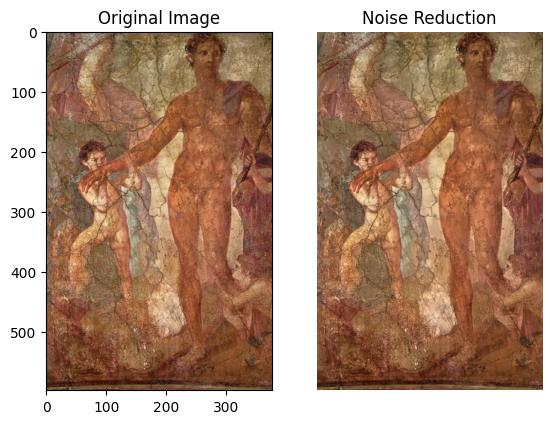

In [19]:
image_ref = cv.imread(path_image_ref, cv.IMREAD_UNCHANGED)
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(image_ref, cv.COLOR_BGR2RGB))
plt.title("Original Image")

image_ref = cv.fastNlMeansDenoisingColored(image_ref)
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(image_ref, cv.COLOR_BGR2RGB))
plt.title("Noise Reduction")
plt.axis("off")
plt.show()

# Feature Extraction

To extract relevant features from the fragments, we employ two methods:
- Color Histograms
- Gradient Jacobians

## Color Histograms

Color histograms are graphical representations of the distribution of colors in an image. They quantify the number of pixels that have specific color values, effectively capturing the color composition of the image. By analyzing the color histograms of image fragments, we can compare and cluster similar fragments based on their color distributions.

**This technique is particularly useful for identifying and matching regions of images that share similar color patterns**.

In [21]:
unflatten_color_histograms_fragments, unflatten_color_histogram_image_ref = compute_color_histograms(images, image_ref, flatten=False)
unflatten_color_histogram_image_ref

Computing color histograms: 100%|██████████| 328/328 [00:00<00:00, 88035.56it/s]


array([[[2.57901818e-04, 3.83700617e-02, 1.50156179e-02, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.36748164e-03, 1.92538038e-01, 1.03647880e-01,
         1.14623035e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 5.73115176e-05, 2.55036261e-03,
         8.59672728e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00

In [23]:
distance_matrix_color_histogram = compute_color_histogram_dist_matrix(unflatten_color_histograms_fragments)
distance_matrix_color_histogram

Calculating similarities: 100%|██████████| 328/328 [00:00<00:00, 1341.48it/s]


array([[ 0.        ,  0.94099119,  0.70407303, ...,  0.68840727,
        18.71498171, 10.45640334],
       [ 0.94099119,  0.        ,  0.53312135, ...,  0.52093016,
         0.54443817,  2.4476498 ],
       [ 0.70407303,  0.53312135,  0.        , ...,  0.15362315,
         0.74818506,  1.14708026],
       ...,
       [ 0.68840727,  0.52093016,  0.15362315, ...,  0.        ,
         0.46151521,  8.52518236],
       [18.71498171,  0.54443817,  0.74818506, ...,  0.46151521,
         0.        ,  8.74787502],
       [10.45640334,  2.4476498 ,  1.14708026, ...,  8.52518236,
         8.74787502,  0.        ]])

### K-Means

In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
fit_kmeans = kmeans.fit(flatten_color_histograms)
create_cluster_dirs(data_dir="./data", output_dir="clusters/kmeans/colors", labels=fit_kmeans.labels_)

### DBSCAN

In [6]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=10, metric="precomputed")
fit_db = db.fit(distance_matrix_color_histogram)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(fit_db.labels_)) - (1 if -1 in fit_db.labels_ else 0)
n_noise_ = list(fit_db.labels_).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

create_cluster_dirs(data_dir="./data", output_dir="clusters/dbscan/colors", labels= fit_db.labels_)

## Gradient Jacobians

Gradient Jacobians represent the gradients of pixel intensities in an image. They capture the rate of change of pixel values in both the horizontal and vertical directions, highlighting edges and texture details. By computing the Jacobians of image fragments, we can compare and group fragments that exhibit similar edge and texture patterns. Formally, the gradient jacobians we use are of the form:

$$
\begin{align}
\begin{bmatrix} G_x & G_{x\_gray} \\ G_y & G_{y\_gray} \end{bmatrix}
\end{align}
$$

where $G_x$ and $G_y$ are the aggregated gradient of the RGB channels, while $G_{x\_gray}$ and $G_{y\_gray}$ are the gradient of the grayscale image.

This method is especially valuable for identifying structural similarities and continuities between different fragments.

In [4]:
unflatten_jacobians_fragments, unflatten_jacobian_image_ref = compute_jacobians(images, image_ref, flatten=False)

In [5]:
distance_matrix_jacobians = compute_jacobians_dist_matrix(unflatten_jacobians_fragments, unflatten_jacobian_image_ref)
distance_matrix_jacobians

### K-Means

In [9]:
# from sklearn.cluster import KMeans
#
# kmeans = KMeans(n_clusters=3, random_state=42)
# fit_kmeans = kmeans.fit(flatten_jacobians)
# create_cluster_dirs(data_dir="./data", output_dir="clusters/kmeans/jacobians", labels=fit_kmeans.labels_)

### DBSCAN

In [6]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10, metric="precomputed")
fit_db = db.fit(distance_matrix_jacobians)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(fit_db.labels_)) - (1 if -1 in fit_db.labels_ else 0)
n_noise_ = list(fit_db.labels_).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

create_cluster_dirs(data_dir="./data", output_dir="clusters/dbscan/jacobians", labels= fit_db.labels_)

In [12]:
img = cv.imread("./data/5.33.20.png", cv.IMREAD_UNCHANGED)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# define each block as 4x4 cells of 64x64 pixels each
cell_size = (5, 5)      # h x w in pixels
block_size = (1, 1)         # h x w in cells
win_size = (2, 2)           # h x w in cells

nbins = 9  # number of orientation bins
img_size = img.shape[:2]  # h x w in pixels

# create a HOG object
hog = cv.HOGDescriptor(
    _winSize=(win_size[1] * cell_size[1],
              win_size[0] * cell_size[0]),
    _blockSize=(block_size[1] * cell_size[1],
                block_size[0] * cell_size[0]),
    _blockStride=(cell_size[1], cell_size[0]),
    _cellSize=(cell_size[1], cell_size[0]),
    _nbins=nbins
)
n_cells = (img_size[0] // cell_size[0], img_size[1] // cell_size[1])

# find features as a 1xN vector, then reshape into spatial hierarchy
hog_feats_1 = hog.compute(gray)
hog_feats_1

array([0.35631186, 0.35631186, 0.35631186, ..., 0.42116162, 0.42116162,
       0.42116162], dtype=float32)

In [13]:
img = cv.imread("./data/5.33.21.png", cv.IMREAD_UNCHANGED)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# define each block as 4x4 cells of 64x64 pixels each
cell_size = (5, 5)      # h x w in pixels
block_size = (1, 1)         # h x w in cells
win_size = (2, 2)           # h x w in cells

nbins = 9  # number of orientation bins
img_size = img.shape[:2]  # h x w in pixels

# create a HOG object
hog = cv.HOGDescriptor(
    _winSize=(win_size[1] * cell_size[1],
              win_size[0] * cell_size[0]),
    _blockSize=(block_size[1] * cell_size[1],
                block_size[0] * cell_size[0]),
    _blockStride=(cell_size[1], cell_size[0]),
    _cellSize=(cell_size[1], cell_size[0]),
    _nbins=nbins
)
n_cells = (img_size[0] // cell_size[0], img_size[1] // cell_size[1])

# find features as a 1xN vector, then reshape into spatial hierarchy
hog_feats = hog.compute(gray)
hog_feats

array([0.3738979 , 0.3738979 , 0.3738979 , ..., 0.3603473 , 0.18820462,
       0.13665415], dtype=float32)

In [14]:
pairwise_distances(hog_feats_1.reshape(1, -1), hog_feats.reshape(1, -1))

array([[9.167723]], dtype=float32)

In [15]:
hog_feats_1.reshape(1, -1)

array([[0.35631186, 0.35631186, 0.35631186, ..., 0.42116162, 0.42116162,
        0.42116162]], dtype=float32)